In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Reading

In [2]:
accts=pd.read_csv('accts.csv')
print(accts.shape)
accts.head()

(2830, 6)


,client_id,acct_id,product,opening_date,open_bal,close_date
0,d8334f42,3f7653c6,A,20130610.0,5.0,NaN
1,365cf2a4,b4771dbf,A,20130726.0,5.0,NaN
2,5e22a673,400e45eb,A,20130802.0,5.0,NaN
3,7da2b1c7,4b100afa,A,20130802.0,5.0,NaN
4,bc2eb9ef,acb8d4cb,A,20130816.0,5.0,NaN


In [3]:
bal=pd.read_csv('bal.csv')
print(bal.shape)
bal.head()

(32311, 3)


,acct_id,bal_date,balance
0,bd7792a7,20130429,10.0
1,bd7792a7,20130429,5.0
2,bd7792a7,20130430,4.0
3,ead948e6,20131130,3.0
4,bd7792a7,20130422,5.0


In [4]:
clients=pd.read_csv('clients.csv')
print(clients.shape)
clients.head()

(2826, 4)


,client_id,gender,dob,enroll_date
0,d8334f42,M,19880617.0,20130610
1,4ab8d76e,M,19601227.0,20130807
2,bc2eb9ef,M,19881107.0,20130816
3,897cb739,M,19820503.0,20130815
4,2cb92776,M,19930923.0,20130805


In [5]:
tx=pd.read_csv('tx.csv')
print(tx.shape)
tx.head()

(32986, 4)


,acct_id,tx_date,amount,type
0,bd7792a7,20130422,5.0,fee_pos_pos_kit
1,bd7792a7,20130429,5.0,sys_rev_of_dr
2,bd7792a7,20130429,-5.0,pos_wd_cash
3,3cbca000,20130508,5.0,sys_rev_of_dr
4,a294d6c4,20131130,-1.0,pos_wd_cash


# Monthly Balance
Given the lack of confidence on the Balance table (as it is not always updated), a new  balance table will be calculated. For simplicity, it will use the inital balance from the _bal_ table, and the different balances from the rest of the time period will be calculated by using the _tx_ table.

A dataframe that shows only the first balance per client is created:

In [6]:
bal['month']=np.round(bal.bal_date/100, 0)
bal2=bal.groupby(['acct_id']).head(1)
bal2.rename(columns={'bal_date':'date',
                    'balance': 'amount'}, inplace=True)
bal2.tail()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,acct_id,date,amount,month
31921,f7484d11,20160226,80.0,201602.0
31997,8d035a99,20160229,0.0,201602.0
32277,1c7f2e34,20160301,0.0,201603.0
32284,11a44ed8,20160301,0.0,201603.0
32300,afc2aba6,20160301,10.0,201603.0


The first transaction per client is eliminated, as it is the one that corresponds to the first reported balance.

In [7]:
firsttx=tx.groupby(['acct_id']).head(1)

tx2=tx[tx.merge(firsttx, on=tx.columns.tolist(), how='outer', indicator=True)._merge=='left_only']
tx2.drop(columns='type', inplace=True)
tx2.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,acct_id,tx_date,amount
1,bd7792a7,20130429,5.0
2,bd7792a7,20130429,-5.0
10,1e175d13,20131113,-0.2
12,bd7792a7,20130524,-2.0
13,bd7792a7,20130524,-0.2


Fictional transactions will be added with an amount of 0, so that every month on the balance table is included for every client on the final table.

In [8]:
all_last_days=[20130430, 20130531, 20130630, 20130731, 20130831, 20130930, 20131031, 20131130, 20131231,
               20140131, 20140228, 20140331, 20140430, 20140531, 20140630, 20140731, 20140831, 20140930, 20141031, 20141130, 20141231,
               20150131, 20150228, 20150331, 20150430, 20150531, 20150630, 20150731, 20150831, 20150930, 20151031, 20151130, 20151231,
               20160131, 20160229, 20160331]

all_clients=bal.acct_id.unique()

combinat = [(i,j) for i in all_last_days for j in all_clients]


fict_tx=pd.DataFrame(combinat, columns=['tx_date', 'acct_id'])
fict_tx['amount']=0

tx2=pd.concat([tx2, fict_tx])
tx2.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,acct_id,amount,tx_date
1,bd7792a7,5.0,20130429
2,bd7792a7,-5.0,20130429
10,1e175d13,-0.2,20131113
12,bd7792a7,-2.0,20130524
13,bd7792a7,-0.2,20130524


A table that combines transactions into the total daily operations done per client is created. 

In [9]:
tx3=tx2.groupby(['acct_id', 'tx_date']).sum().amount.reset_index()
tx3.rename(columns={'tx_date':'date'}, inplace=True)
tx3['month']=np.round(tx3.date/100, 0)

tx3.head()

,acct_id,date,amount,month
0,0027968d,20130430,0.0,201304.0
1,0027968d,20130531,0.0,201305.0
2,0027968d,20130630,0.0,201306.0
3,0027968d,20130731,0.0,201307.0
4,0027968d,20130831,0.0,201308.0


The initial balances and daily total transactions tables are combined.

In [10]:
m_status=pd.concat([bal2, tx3]).reset_index(drop=True)
m_status.sort_values('date', inplace=True)
m_status.head()

,acct_id,date,amount,month
0,bd7792a7,20130429,10.0,201304.0
84757,bd7792a7,20130429,0.0,201304.0
100360,df2d9c80,20130430,0.0,201304.0
61634,8711cd01,20130430,0.0,201304.0
37297,4f916aaa,20130430,0.0,201304.0


In [11]:
m_status['new_balance']=m_status.groupby('acct_id')['amount'].cumsum()
m_status.head()

,acct_id,date,amount,month,new_balance
0,bd7792a7,20130429,10.0,201304.0,10.0
84757,bd7792a7,20130429,0.0,201304.0,10.0
100360,df2d9c80,20130430,0.0,201304.0,0.0
61634,8711cd01,20130430,0.0,201304.0,0.0
37297,4f916aaa,20130430,0.0,201304.0,0.0


In [12]:
m_status=m_status.sort_values(['acct_id', 'date'])
m_status.reset_index(inplace=True, drop=True)
m_status.head()

,acct_id,date,amount,month,new_balance
0,0027968d,20130430,0.0,201304.0,0.0
1,0027968d,20130531,0.0,201305.0,0.0
2,0027968d,20130630,0.0,201306.0,0.0
3,0027968d,20130731,0.0,201307.0,0.0
4,0027968d,20130831,0.0,201308.0,0.0


The total days that this balance has been kept during the month is calculated.

In [13]:
m_status['days']=m_status['date']-m_status['month']*100 #Days since start of month.
m_status['days2']=m_status.groupby(['acct_id', 'month'])['days'].diff() #Days since last balance captured.

nulls=np.isnan(m_status['days2']) #Days with no previous client/month combination
m_status['days2'][nulls]=m_status['days'][nulls]

m_status.head(12)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,acct_id,date,amount,month,new_balance,days,days2
0,0027968d,20130430,0.0,201304.0,0.0,30.0,30.0
1,0027968d,20130531,0.0,201305.0,0.0,31.0,31.0
2,0027968d,20130630,0.0,201306.0,0.0,30.0,30.0
3,0027968d,20130731,0.0,201307.0,0.0,31.0,31.0
4,0027968d,20130831,0.0,201308.0,0.0,31.0,31.0
5,0027968d,20130930,0.0,201309.0,0.0,30.0,30.0
6,0027968d,20131031,0.0,201310.0,0.0,31.0,31.0
7,0027968d,20131130,0.0,201311.0,0.0,30.0,30.0
8,0027968d,20131231,0.0,201312.0,0.0,31.0,31.0
9,0027968d,20140131,0.0,201401.0,0.0,31.0,31.0


# Primary Task 
## Monthly balance calculation

In [14]:
daysm=[(int(str(x)[:6]), int(str(x)[6:])) for x in all_last_days]
daysm=pd.DataFrame(daysm, columns=['month', 'daysm'])
daysm.head()

,month,daysm
0,201304,30
1,201305,31
2,201306,30
3,201307,31
4,201308,31


In [15]:
m_status=m_status.merge(daysm, how='left', on='month')
m_status.head()

,acct_id,date,amount,month,new_balance,days,days2,daysm
0,0027968d,20130430,0.0,201304.0,0.0,30.0,30.0,30
1,0027968d,20130531,0.0,201305.0,0.0,31.0,31.0,31
2,0027968d,20130630,0.0,201306.0,0.0,30.0,30.0,30
3,0027968d,20130731,0.0,201307.0,0.0,31.0,31.0,31
4,0027968d,20130831,0.0,201308.0,0.0,31.0,31.0,31


In [16]:
m_status['helper']=(m_status['days2']/m_status['daysm'])*m_status['new_balance']

primary_task=m_status.groupby(['acct_id', 'month'])[['new_balance']].sum()
primary_task.reset_index(inplace=True)
primary_task.rename(columns={'month':'yyyymm', 'new_balance':'avg_balance'}, inplace=True)
primary_task.tail()

,acct_id,yyyymm,avg_balance
96732,ffeb404e,201511.0,5.0
96733,ffeb404e,201512.0,5.0
96734,ffeb404e,201601.0,5.0
96735,ffeb404e,201602.0,5.0
96736,ffeb404e,201603.0,5.0


# Secondary Task

### Evolution of monthly balance

In [17]:
ts=primary_task[primary_task.avg_balance>0] # To only include clients with a positive balance
ts=ts.groupby('yyyymm').mean()
ts.reset_index(inplace=True)
ts.yyyymm=pd.to_datetime(ts.yyyymm, format='%Y%m')
ts.head()

,yyyymm,avg_balance
0,2013-04-01,29.000000
1,2013-05-01,15.520000
2,2013-06-01,41.239893
3,2013-07-01,11.307296
4,2013-08-01,41.398633


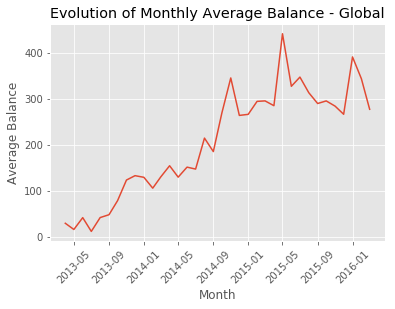

In [63]:
plt.style.use('ggplot')

plt.title('Evolution of Monthly Average Balance - Global')
plt.plot(ts.yyyymm, ts.avg_balance)
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.ylabel('Average Balance')
plt.show()

There is no observable seasonal effect on the time series. There is, however a positive trend that seems to become stationary around january 2015.

### Clients by enrollment day

In [19]:
clients.head()
enroll=clients[['gender', 'enroll_date']].copy()
enroll['month']=np.round(enroll.enroll_date/100, 0).astype(int)

enroll['month']=pd.to_datetime(enroll.month.astype(str), format='%Y%m')

enroll.head()

,gender,enroll_date,month
0,M,20130610,2013-06-01
1,M,20130807,2013-08-01
2,M,20130816,2013-08-01
3,M,20130815,2013-08-01
4,M,20130805,2013-08-01


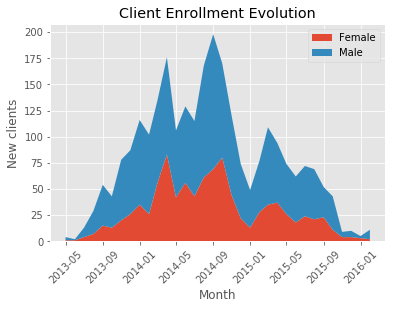

In [28]:
enrollg=enroll.groupby(['month', 'gender']).count().reset_index()

enrollgm=enrollg[enrollg.gender=='M']
enrollgf=enrollg[enrollg.gender=='F']
plt.stackplot(enrollgm['month'], enrollgf['enroll_date'], enrollgm['enroll_date'], labels=['Female', 'Male'])
plt.title('Client Enrollment Evolution')
plt.ylabel('New clients')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.legend()
plt.show()

### Clients age at time of enrollment

In [47]:
born=pd.to_datetime(clients.dob.astype(str), format='%Y%m%d')
enrolld=pd.to_datetime(clients.enroll_date.astype(str), format='%Y%m%d')

age=(enrolld-born)
age=age.dt.days
age=age.dropna(how='any')

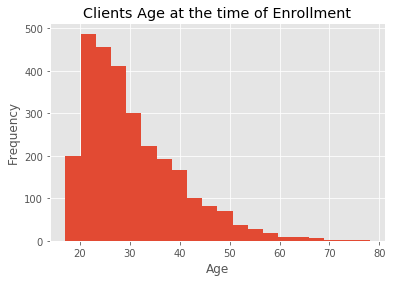

In [55]:
(age/365).hist(bins=20) #Not exact age (still have to consider leap years), but serves as a reference.

plt.title('Clients Age at the time of Enrollment')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()